# Capstone Project
## Neural translation model
### Instructions

In this notebook, you will create a neural network that translates from English to German. You will use concepts from throughout this course, including building more flexible model architectures, freezing layers, data processing pipeline and sequence modelling.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re

![Flags overview image](data/germany_uk_flags.png)

For the capstone project, you will use a language dataset from http://www.manythings.org/anki/ to build a neural translation model. This dataset consists of over 200,000 pairs of sentences in English and German. In order to make the training quicker, we will restrict to our dataset to 20,000 pairs. Feel free to change this if you wish - the size of the dataset used is not part of the grading rubric.

Your goal is to develop a neural translation model from English to German, making use of a pre-trained English word embedding module.

In [2]:
# Run this cell to load the dataset

NUM_EXAMPLES = 20000
data_examples = []
with open('data/deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [3]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

#### The custom translation model
The following is a schematic of the custom translation model architecture you will develop in this project.

![Model Schematic](data/neural_translation_model.png)

Key:
![Model key](data/neural_translation_model_key.png)

The custom model consists of an encoder RNN and a decoder RNN. The encoder takes words of an English sentence as input, and uses a pre-trained word embedding to embed the words into a 128-dimensional space. To indicate the end of the input sentence, a special end token (in the same 128-dimensional space) is passed in as an input. This token is a TensorFlow Variable that is learned in the training phase (unlike the pre-trained word embedding, which is frozen).

The decoder RNN takes the internal state of the encoder network as its initial state. A start token is passed in as the first input, which is embedded using a learned German word embedding. The decoder RNN then makes a prediction for the next German word, which during inference is then passed in as the following input, and this process is repeated until the special `<end>` token is emitted from the decoder.

## 1. Text preprocessing
* Create separate lists of English and German sentences, and preprocess them using the `preprocess_sentence` function provided for you above.
* Add a special `"<start>"` and `"<end>"` token to the beginning and end of every German sentence.
* Use the Tokenizer class from the `tf.keras.preprocessing.text` module to tokenize the German sentences, ensuring that no character filters are applied. _Hint: use the Tokenizer's "filter" keyword argument._
* Print out at least 5 randomly chosen examples of (preprocessed) English and German sentence pairs. For the German sentence, print out the text (with start and end tokens) as well as the tokenized sequence.
* Pad the end of the tokenized German sequences with zeros, and batch the complete set of sequences into one numpy array.

In [4]:
# Inspect the first few data examples

data_examples[:5]

['Hi.\tHallo!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)\n',
 'Hi.\tGrüß Gott!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)\n',
 'Run!\tLauf!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)\n',
 'Wow!\tPotzdonner!\tCC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122382 (Pfirsichbaeumchen)\n',
 'Wow!\tDonnerwetter!\tCC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122391 (Pfirsichbaeumchen)\n']

In [5]:
# Extract the English and the German sentences

english = [l.split("\t")[0] for l in data_examples]
german = [l.split("\t")[1] for l in data_examples]

In [6]:
# Preprocess the language datasets

import numpy as np 

english = np.array([preprocess_sentence(s) for s in english])
german = np.array([preprocess_sentence(s) for s in german])

In [7]:
# Add start and end tokens

german = np.array(["<start> {} <end>".format(s) for s in german])

In [8]:
# Tokenize the German sequences

from tensorflow.keras.preprocessing.text import Tokenizer

german_tokenizer = Tokenizer(filters='')
german_tokenizer.fit_on_texts(german)

In [9]:
# Convert the German sentences to token sequences

tokenized_german_sequences = german_tokenizer.texts_to_sequences(german)

In [10]:
# Inspect a few examples of each

inx = np.random.choice(len(english), 5, replace=False)

for eng, ger in zip(english[inx], german[inx]):
    print(eng)
    print(ger)
    print(german_tokenizer.texts_to_sequences(ger.split()))
    print('')

don't show off .
<start> gib nicht an . <end>
[[1], [93], [12], [36], [3], [2]]

we'll be busy .
<start> wir werden beschaeftigt sein . <end>
[[1], [17], [69], [98], [54], [3], [2]]

i don't remember .
<start> ich erinnere mich nicht mehr . <end>
[[1], [4], [685], [22], [12], [144], [3], [2]]

tom always wins .
<start> tom gewinnt immer . <end>
[[1], [5], [716], [192], [3], [2]]

i got it for free .
<start> ich erhielt es ohne bezahlung . <end>
[[1], [4], [3096], [10], [746], [2901], [3], [2]]



In [11]:
# Pad the tokenized sequences with zeros

from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_german_seq = pad_sequences(tokenized_german_sequences, padding="post")

In [12]:
# Get the number of tokens

num_german_tokens = max(german_tokenizer.index_word.keys()) + 1
print(num_german_tokens)

5744


## 2. Prepare the data

#### Load the embedding layer
As part of the dataset preproceessing for this project, you will use a pre-trained English word embedding module from TensorFlow Hub. The URL for the module is https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1. This module has also been made available as a complete saved model in the folder `'./models/embedding'`. 

This embedding takes a batch of text tokens in a 1-D tensor of strings as input. It then embeds the separate tokens into a 128-dimensional space. 

The code to load and test the embedding layer is provided for you below.

**NB:** this model can also be used as a sentence embedding module. The module will process each token by removing punctuation and splitting on spaces. It then averages the word embeddings over a sentence to give a single embedding vector. However, we will use it only as a word embedding module, and will pass each word in the input sentence as a separate token.

In [13]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [14]:
# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

You should now prepare the training and validation Datasets.

* Create a random training and validation set split of the data, reserving e.g. 20% of the data for validation (NB: each English dataset example is a single sentence string, and each German dataset example is a sequence of padded integer tokens).
* Load the training and validation sets into a tf.data.Dataset object, passing in a tuple of English and German data for both training and validation sets.
* Create a function to map over the datasets that splits each English sentence at spaces. Apply this function to both Dataset objects using the map method. _Hint: look at the tf.strings.split function._
* Create a function to map over the datasets that embeds each sequence of English words using the loaded embedding layer/model. Apply this function to both Dataset objects using the map method.
* Create a function to filter out dataset examples where the English sentence is more than 13 (embedded) tokens in length. Apply this function to both Dataset objects using the filter method.
* Create a function to map over the datasets that pads each English sequence of embeddings with some distinct padding value before the sequence, so that each sequence is length 13. Apply this function to both Dataset objects using the map method. _Hint: look at the tf.pad function. You can extract a Tensor shape using tf.shape; you might also find the tf.math.maximum function useful._
* Batch both training and validation Datasets with a batch size of 16.
* Print the `element_spec` property for the training and validation Datasets. 
* Using the Dataset `.take(1)` method, print the shape of the English data example from the training Dataset.
* Using the Dataset `.take(1)` method, print the German data example Tensor from the validation Dataset.

In [15]:
# Create training, test and validation splits

from random import shuffle
from sklearn.model_selection import train_test_split

english_train, english_valid, german_train, german_valid = train_test_split(english, 
                                                                            padded_german_seq, 
                                                                            test_size=0.2)

In [16]:
# Create a translation Dataset

eng_ger_train = tf.data.Dataset.from_tensor_slices((english_train, german_train))
eng_ger_valid = tf.data.Dataset.from_tensor_slices((english_valid, german_valid))
eng_ger_train.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(14,), dtype=tf.int32, name=None))

In [17]:
# Split the English sentences at spaces

def split_at_spaces(eng, ger):
    return tf.strings.split(eng), ger

eng_ger_train = eng_ger_train.map(split_at_spaces)
eng_ger_valid = eng_ger_valid.map(split_at_spaces)
eng_ger_train.element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(14,), dtype=tf.int32, name=None))

In [18]:
# Get the embeddings for the English sentences

def get_embedding(eng, ger):
    return embedding_layer(eng), ger

eng_ger_train = eng_ger_train.map(get_embedding)
eng_ger_valid = eng_ger_valid.map(get_embedding)
eng_ger_train.element_spec

(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None),
 TensorSpec(shape=(14,), dtype=tf.int32, name=None))

In [19]:
# Filter out examples where the English sentence is longer than 13 tokens

max_english_sentence_len = 13

def filter_long_sentences(eng, ger):
    return tf.shape(eng)[0] <= max_english_sentence_len

eng_ger_train = eng_ger_train.filter(filter_long_sentences)
eng_ger_valid = eng_ger_valid.filter(filter_long_sentences)
eng_ger_train.element_spec

(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None),
 TensorSpec(shape=(14,), dtype=tf.int32, name=None))

In [20]:
# Pad the English sentences

def pad_embedding_sequences(eng, ger):
    length_emb = tf.shape(eng)[0]
    padding = [[tf.math.maximum(0, max_english_sentence_len - length_emb), 0], [0, 0]]
    return tf.pad(eng, padding, 'CONSTANT', constant_values=-1000), ger

eng_ger_train = eng_ger_train.map(pad_embedding_sequences)
eng_ger_valid = eng_ger_valid.map(pad_embedding_sequences)
eng_ger_train.element_spec

(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None),
 TensorSpec(shape=(14,), dtype=tf.int32, name=None))

In [21]:
# Batch the Datasets

eng_ger_train = eng_ger_train.batch(16)
eng_ger_valid = eng_ger_valid.batch(16)

In [22]:
# Print the final training Dataset element_spec

eng_ger_train.element_spec

(TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))

In [23]:
# Print the final validation Dataset element_spec

eng_ger_valid.element_spec

(TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))

In [24]:
# Print the shape of a batch of English data examples

for eng, ger in eng_ger_train.take(1):
    print(eng.shape)

(16, 13, 128)


In [25]:
# Print a batch of German data examples

for eng, ger in eng_ger_valid.take(1):
    print(ger)

tf.Tensor(
[[   1   17   23   12  139    3    2    0    0    0    0    0    0    0]
 [   1    4   15  186    5    3    2    0    0    0    0    0    0    0]
 [   1   43   16  926    7    2    0    0    0    0    0    0    0    0]
 [   1   14   16 2290    3    2    0    0    0    0    0    0    0    0]
 [   1    5 3714    3    2    0    0    0    0    0    0    0    0    0]
 [   1   11    6   12  884    3    2    0    0    0    0    0    0    0]
 [   1   10    6 3061    3    2    0    0    0    0    0    0    0    0]
 [   1    5   24   12  755    3    2    0    0    0    0    0    0    0]
 [   1    5  136   65   75    3    2    0    0    0    0    0    0    0]
 [   1    5  105    3    2    0    0    0    0    0    0    0    0    0]
 [   1   10  111   22  171    3    2    0    0    0    0    0    0    0]
 [   1   11   30  305   46   47 1913  471    3    2    0    0    0    0]
 [   1   14  229   34  598  694    3    2    0    0    0    0    0    0]
 [   1    4   15   70  179   42   13    

## 3. Create the custom layer
You will now create a custom layer to add the learned end token embedding to the encoder model:

![Encoder schematic](data/neural_translation_model_encoder.png)

You should now build the custom layer.
* Using layer subclassing, create a custom layer that takes a batch of English data examples from one of the Datasets, and adds a learned embedded ‘end’ token to the end of each sequence. 
* This layer should create a TensorFlow Variable (that will be learned during training) that is 128-dimensional (the size of the embedding space). _Hint: you may find it helpful in the call method to use the tf.tile function to replicate the end token embedding across every element in the batch._
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and print the shape. Test the custom layer by calling the layer on the English data batch Tensor and print the resulting Tensor shape (the layer should increase the sequence length by one).

In [26]:
# Create the custom layer to add an end token embedding

class AddEndToken(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super(AddEndToken, self).__init__(**kwargs)
    
    def build(self, input_shape):
        embedding_size = input_shape[-1]
        self.end_token = self.add_weight(shape=(1, embedding_size), 
                                         initializer='random_normal',
                                         name='english_end_token')
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        token = tf.tile(tf.expand_dims(self.end_token, 0), [batch_size, 1, 1])
        return tf.concat([inputs, token], 1)

In [27]:
# Test the layer

add_end_token = AddEndToken()

for eng, ger in eng_ger_train.take(1):
    print(eng.shape)
    print(add_end_token(eng).shape)

(16, 13, 128)
(16, 14, 128)


## 4. Build the encoder network
The encoder network follows the schematic diagram above. You should now build the RNN encoder model.
* Using the functional API, build the encoder network according to the following spec:
    * The model will take a batch of sequences of embedded English words as input, as given by the Dataset objects.
    * The next layer in the encoder will be the custom layer you created previously, to add a learned end token embedding to the end of the English sequence.
    * This is followed by a Masking layer, with the `mask_value` set to the distinct padding value you used when you padded the English sequences with the Dataset preprocessing above.
    * The final layer is an LSTM layer with 512 units, which also returns the hidden and cell states.
    * The encoder is a multi-output model. There should be two output Tensors of this model: the hidden state and cell states of the LSTM layer. The output of the LSTM layer is unused.
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and test the encoder model by calling it on the English data Tensor, and print the shape of the resulting Tensor outputs.
* Print the model summary for the encoder network.

In [28]:
# Build the encoder

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Masking

def get_encoder():
    encoder_input = Input(shape=(None, 128))
    h = AddEndToken()(encoder_input)
    h = Masking(mask_value=-1000)(h)
    enc_output, enc_hidden, enc_cell = LSTM(512, return_state=True)(h)

    return Model(inputs=encoder_input, outputs=[enc_hidden, enc_cell])

encoder = get_encoder()

In [29]:
# Test the encoder

for eng, ger in eng_ger_train.take(1):
    print([t.shape for t in encoder(eng)])

[TensorShape([16, 512]), TensorShape([16, 512])]


In [30]:
# Print the encoder summary

encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 128)]       0         
_________________________________________________________________
add_end_token_1 (AddEndToken (None, None, 128)         128       
_________________________________________________________________
masking (Masking)            (None, None, 128)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 512), (None, 512) 1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


## 5. Build the decoder network
The decoder network follows the schematic diagram below. 

![Decoder schematic](data/neural_translation_model_decoder.png)

You should now build the RNN decoder model.
* Using Model subclassing, build the decoder network according to the following spec:
    * The initializer should create the following layers:
        * An Embedding layer with vocabulary size set to the number of unique German tokens, embedding dimension 128, and set to mask zero values in the input.
        * An LSTM layer with 512 units, that returns its hidden and cell states, and also returns sequences.
        * A Dense layer with number of units equal to the number of unique German tokens, and no activation function.
    * The call method should include the usual `inputs` argument, as well as the additional keyword arguments `hidden_state` and `cell_state`. The default value for these keyword arguments should be `None`.
    * The call method should pass the inputs through the Embedding layer, and then through the LSTM layer. If the `hidden_state` and `cell_state` arguments are provided, these should be used for the initial state of the LSTM layer. _Hint: use the_ `initial_state` _keyword argument when calling the LSTM layer on its input._
    * The call method should pass the LSTM output sequence through the Dense layer, and return the resulting Tensor, along with the hidden and cell states of the LSTM layer. 
* Using the Dataset `.take(1)` method, extract a batch of English and German data examples from the training Dataset. Test the decoder model by first calling the encoder model on the English data Tensor to get the hidden and cell states, and then call the decoder model on the German data Tensor and hidden and cell states, and print the shape of the resulting decoder Tensor outputs.
* Print the model summary for the decoder network.

In [31]:
# Build the decoder

from tensorflow.keras.layers import Dense, Embedding

class Decoder(Model):
    
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.embedding = Embedding(num_german_tokens, 128, mask_zero=True)
        self.lstm = LSTM(512, return_state=True, return_sequences=True)
        self.dense = Dense(num_german_tokens)
        
    def call(self, inputs, hidden_state=None, cell_state=None, training=True):
        if hidden_state is None:
            assert cell_state is None
            h = self.embedding(inputs)
            o, h, c = self.lstm(h)
        else:
            h = self.embedding(inputs)
            o, h, c = self.lstm(h, initial_state=[hidden_state, cell_state])
        return self.dense(o), h, c
    
decoder = Decoder()

In [32]:
# Test the decoder

for eng, ger in eng_ger_train.take(1):
    hidden, cell = encoder(eng)
    print([t.shape for t in decoder(ger, hidden_state=hidden, cell_state=cell)])

[TensorShape([16, 14, 5744]), TensorShape([16, 512]), TensorShape([16, 512])]


In [33]:
# Print the decoder summary

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  735232    
_________________________________________________________________
lstm_1 (LSTM)                multiple                  1312768   
_________________________________________________________________
dense (Dense)                multiple                  2946672   
Total params: 4,994,672
Trainable params: 4,994,672
Non-trainable params: 0
_________________________________________________________________


## 6. Make a custom training loop
You should now write a custom training loop to train your custom neural translation model.
* Define a function that takes a Tensor batch of German data (as extracted from the training Dataset), and returns a tuple containing German inputs and outputs for the decoder model (refer to schematic diagram above).
* Define a function that computes the forward and backward pass for your translation model. This function should take an English input, German input and German output as arguments, and should do the following:
    * Pass the English input into the encoder, to get the hidden and cell states of the encoder LSTM.
    * These hidden and cell states are then passed into the decoder, along with the German inputs, which returns a sequence of outputs (the hidden and cell state outputs of the decoder LSTM are unused in this function).
    * The loss should then be computed between the decoder outputs and the German output function argument.
    * The function returns the loss and gradients with respect to the encoder and decoder’s trainable variables.
    * Decorate the function with `@tf.function`
* Define and run a custom training loop for a number of epochs (for you to choose) that does the following:
    * Iterates through the training dataset, and creates decoder inputs and outputs from the German sequences.
    * Updates the parameters of the translation model using the gradients of the function above and an optimizer object.
    * Every epoch, compute the validation loss on a number of batches from the validation and save the epoch training and validation losses.
* Plot the learning curves for loss vs epoch for both training and validation sets.

_Hint: This model is computationally demanding to train. The quality of the model or length of training is not a factor in the grading rubric. However, to obtain a better model we recommend using the GPU accelerator hardware on Colab._

In [34]:
# Define the loss function and optimizer

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [35]:
# Function to create German tokens inputs and outputs

def get_german_inputs_outputs(ger_in):
    return ger_in[:, :-1], ger_in[:, 1:]

In [36]:
# Define the forward and backward pass

@tf.function
def get_loss_and_grads(eng_in, ger_in, ger_out):
    with tf.GradientTape() as tape:
        h, c = encoder(eng_in)
        outputs, _1, _2 = decoder(ger_in, hidden_state=h, cell_state=c)
        current_loss = loss_fn(ger_out, outputs)
        grads = tape.gradient(current_loss, 
                              encoder.trainable_variables + decoder.trainable_variables)
    return current_loss, grads

In [37]:
# For evaluation

@tf.function
def get_loss(eng_in, ger_in, ger_out):
    h, c = encoder(eng_in)
    outputs, _1, _2 = decoder(ger_in, hidden_state=h, cell_state=c)
    return loss_fn(ger_out, outputs)

In [38]:
# Run the custom training loop

num_epochs = 8
num_valid_steps = 100

epoch_history = {
    'epoch': [],
    'loss': [],
    'val_loss': []
}
batch_history = {
    'iteration': [],
    'loss': []
}

for epoch in range(num_epochs):
    epoch_loss = tf.keras.metrics.Mean()
    
    for iteration, (eng, ger) in enumerate(eng_ger_train):      
        ger_inputs, ger_outputs = get_german_inputs_outputs(ger)
        loss, grads = get_loss_and_grads(eng, ger_inputs, ger_outputs)
        epoch_loss(loss)
        print("Iteration {}, loss: {}".format(iteration, loss))
        if iteration % 10 == 0:
            batch_history['iteration'].append(iteration)
            batch_history['loss'].append(loss)
        optimizer.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))
    print("End of epoch {}, loss: {}".format(epoch, epoch_loss.result() + 1))
    
    # Validation
    for (eng, ger) in eng_ger_valid.take(num_valid_steps):
        valid_loss = tf.keras.metrics.Mean()
        ger_inputs, ger_outputs = get_german_inputs_outputs(ger)
        valid_loss(get_loss(eng, ger_inputs, ger_outputs))
    print("Validation loss: {}".format(valid_loss.result()))
    
    epoch_history['epoch'].append(epoch)
    epoch_history['loss'].append(epoch_loss.result())
    epoch_history['val_loss'].append(valid_loss.result())

Iteration 0, loss: 8.655912399291992
Iteration 1, loss: 8.635028839111328
Iteration 2, loss: 8.60886001586914
Iteration 3, loss: 8.566322326660156
Iteration 4, loss: 8.456841468811035
Iteration 5, loss: 8.227700233459473
Iteration 6, loss: 7.824914932250977
Iteration 7, loss: 6.820156574249268
Iteration 8, loss: 5.2808356285095215
Iteration 9, loss: 3.9917826652526855
Iteration 10, loss: 3.2279088497161865
Iteration 11, loss: 3.0389530658721924
Iteration 12, loss: 3.1221323013305664
Iteration 13, loss: 3.4461424350738525
Iteration 14, loss: 3.5340871810913086
Iteration 15, loss: 2.952766180038452
Iteration 16, loss: 2.7531867027282715
Iteration 17, loss: 3.015176296234131
Iteration 18, loss: 3.20509934425354
Iteration 19, loss: 3.2630488872528076
Iteration 20, loss: 2.9524271488189697
Iteration 21, loss: 3.3425114154815674
Iteration 22, loss: 3.1199440956115723
Iteration 23, loss: 2.8790102005004883
Iteration 24, loss: 2.9415664672851562
Iteration 25, loss: 3.010601282119751
Iteration 

Iteration 210, loss: 1.714845895767212
Iteration 211, loss: 1.6026880741119385
Iteration 212, loss: 1.6192811727523804
Iteration 213, loss: 2.062117338180542
Iteration 214, loss: 1.7502083778381348
Iteration 215, loss: 1.9127240180969238
Iteration 216, loss: 1.8191217184066772
Iteration 217, loss: 1.9588053226470947
Iteration 218, loss: 1.9710876941680908
Iteration 219, loss: 1.8170711994171143
Iteration 220, loss: 2.0302748680114746
Iteration 221, loss: 1.7997534275054932
Iteration 222, loss: 1.8981198072433472
Iteration 223, loss: 1.7633612155914307
Iteration 224, loss: 1.6681932210922241
Iteration 225, loss: 1.770322322845459
Iteration 226, loss: 1.802842617034912
Iteration 227, loss: 1.7241777181625366
Iteration 228, loss: 1.7086976766586304
Iteration 229, loss: 1.6813489198684692
Iteration 230, loss: 1.8190544843673706
Iteration 231, loss: 1.885552167892456
Iteration 232, loss: 1.893829584121704
Iteration 233, loss: 1.9196141958236694
Iteration 234, loss: 1.938598394393921
Iterati

Iteration 417, loss: 1.4987716674804688
Iteration 418, loss: 1.6620758771896362
Iteration 419, loss: 1.6464729309082031
Iteration 420, loss: 1.7159650325775146
Iteration 421, loss: 1.6438196897506714
Iteration 422, loss: 1.5131269693374634
Iteration 423, loss: 1.5377373695373535
Iteration 424, loss: 1.6043601036071777
Iteration 425, loss: 1.557814359664917
Iteration 426, loss: 1.6623502969741821
Iteration 427, loss: 1.5288289785385132
Iteration 428, loss: 1.6059048175811768
Iteration 429, loss: 1.6617658138275146
Iteration 430, loss: 1.5277762413024902
Iteration 431, loss: 1.543318510055542
Iteration 432, loss: 1.4939528703689575
Iteration 433, loss: 1.6555216312408447
Iteration 434, loss: 1.6430447101593018
Iteration 435, loss: 1.688241958618164
Iteration 436, loss: 1.741849422454834
Iteration 437, loss: 1.4415481090545654
Iteration 438, loss: 1.5240179300308228
Iteration 439, loss: 1.6382967233657837
Iteration 440, loss: 1.6577398777008057
Iteration 441, loss: 1.4563653469085693
Iter

Iteration 623, loss: 1.4827677011489868
Iteration 624, loss: 1.5131868124008179
Iteration 625, loss: 1.6228021383285522
Iteration 626, loss: 1.551344633102417
Iteration 627, loss: 1.4074991941452026
Iteration 628, loss: 1.5774917602539062
Iteration 629, loss: 1.541279911994934
Iteration 630, loss: 1.6357173919677734
Iteration 631, loss: 1.5648043155670166
Iteration 632, loss: 1.8488667011260986
Iteration 633, loss: 1.5060195922851562
Iteration 634, loss: 1.2574189901351929
Iteration 635, loss: 1.6061055660247803
Iteration 636, loss: 1.483095645904541
Iteration 637, loss: 1.565474271774292
Iteration 638, loss: 1.4212720394134521
Iteration 639, loss: 1.664473056793213
Iteration 640, loss: 1.5610929727554321
Iteration 641, loss: 1.7013453245162964
Iteration 642, loss: 1.5486233234405518
Iteration 643, loss: 1.7751147747039795
Iteration 644, loss: 1.4390833377838135
Iteration 645, loss: 1.696559190750122
Iteration 646, loss: 1.5867890119552612
Iteration 647, loss: 1.390627384185791
Iterati

Iteration 830, loss: 1.4427686929702759
Iteration 831, loss: 1.6903331279754639
Iteration 832, loss: 1.6506693363189697
Iteration 833, loss: 1.5167380571365356
Iteration 834, loss: 1.7291096448898315
Iteration 835, loss: 1.421209454536438
Iteration 836, loss: 1.5934562683105469
Iteration 837, loss: 1.6797419786453247
Iteration 838, loss: 1.2935678958892822
Iteration 839, loss: 1.5062792301177979
Iteration 840, loss: 1.5732135772705078
Iteration 841, loss: 1.3362488746643066
Iteration 842, loss: 1.6774799823760986
Iteration 843, loss: 1.7703239917755127
Iteration 844, loss: 1.6297974586486816
Iteration 845, loss: 1.53129243850708
Iteration 846, loss: 1.3596265316009521
Iteration 847, loss: 1.5220705270767212
Iteration 848, loss: 1.2685067653656006
Iteration 849, loss: 1.4382380247116089
Iteration 850, loss: 1.370127558708191
Iteration 851, loss: 1.4484503269195557
Iteration 852, loss: 1.6140576601028442
Iteration 853, loss: 1.343871831893921
Iteration 854, loss: 1.1869374513626099
Itera

Iteration 36, loss: 1.248718500137329
Iteration 37, loss: 1.545501947402954
Iteration 38, loss: 1.2751802206039429
Iteration 39, loss: 1.552415370941162
Iteration 40, loss: 1.2618954181671143
Iteration 41, loss: 1.3174757957458496
Iteration 42, loss: 1.4657046794891357
Iteration 43, loss: 1.2984089851379395
Iteration 44, loss: 1.5019431114196777
Iteration 45, loss: 1.2770230770111084
Iteration 46, loss: 1.2956968545913696
Iteration 47, loss: 1.2944203615188599
Iteration 48, loss: 1.379738688468933
Iteration 49, loss: 1.5696234703063965
Iteration 50, loss: 1.3393508195877075
Iteration 51, loss: 1.1884865760803223
Iteration 52, loss: 1.4411133527755737
Iteration 53, loss: 1.4069416522979736
Iteration 54, loss: 1.4608489274978638
Iteration 55, loss: 1.5572028160095215
Iteration 56, loss: 1.525432825088501
Iteration 57, loss: 1.3391673564910889
Iteration 58, loss: 1.3848347663879395
Iteration 59, loss: 1.4274147748947144
Iteration 60, loss: 1.3798768520355225
Iteration 61, loss: 1.30769646

Iteration 244, loss: 1.4791032075881958
Iteration 245, loss: 1.3798596858978271
Iteration 246, loss: 1.3974372148513794
Iteration 247, loss: 1.2936155796051025
Iteration 248, loss: 1.1037306785583496
Iteration 249, loss: 1.2524954080581665
Iteration 250, loss: 1.3277451992034912
Iteration 251, loss: 1.7231075763702393
Iteration 252, loss: 1.177909255027771
Iteration 253, loss: 1.063507080078125
Iteration 254, loss: 1.2937273979187012
Iteration 255, loss: 1.3404980897903442
Iteration 256, loss: 1.3927384614944458
Iteration 257, loss: 1.254631519317627
Iteration 258, loss: 1.3205187320709229
Iteration 259, loss: 1.150563359260559
Iteration 260, loss: 1.2599881887435913
Iteration 261, loss: 1.205310344696045
Iteration 262, loss: 1.3236234188079834
Iteration 263, loss: 1.3589844703674316
Iteration 264, loss: 1.2067489624023438
Iteration 265, loss: 1.427370548248291
Iteration 266, loss: 1.3894375562667847
Iteration 267, loss: 1.45262610912323
Iteration 268, loss: 1.4157814979553223
Iteratio

Iteration 450, loss: 1.1570725440979004
Iteration 451, loss: 1.0924663543701172
Iteration 452, loss: 1.2262911796569824
Iteration 453, loss: 1.4291274547576904
Iteration 454, loss: 1.1959596872329712
Iteration 455, loss: 1.2602430582046509
Iteration 456, loss: 0.9281682372093201
Iteration 457, loss: 1.2836158275604248
Iteration 458, loss: 1.4829137325286865
Iteration 459, loss: 1.2945456504821777
Iteration 460, loss: 1.1676126718521118
Iteration 461, loss: 1.3147222995758057
Iteration 462, loss: 1.2088814973831177
Iteration 463, loss: 1.1474946737289429
Iteration 464, loss: 1.3820856809616089
Iteration 465, loss: 1.4372236728668213
Iteration 466, loss: 1.3219287395477295
Iteration 467, loss: 1.3613810539245605
Iteration 468, loss: 1.155311942100525
Iteration 469, loss: 1.217130184173584
Iteration 470, loss: 1.2296264171600342
Iteration 471, loss: 1.4595099687576294
Iteration 472, loss: 1.327129602432251
Iteration 473, loss: 1.1706513166427612
Iteration 474, loss: 1.2417256832122803
Ite

Iteration 656, loss: 1.0551913976669312
Iteration 657, loss: 1.1853861808776855
Iteration 658, loss: 1.2534383535385132
Iteration 659, loss: 1.1483690738677979
Iteration 660, loss: 1.0558675527572632
Iteration 661, loss: 1.1308605670928955
Iteration 662, loss: 1.162298321723938
Iteration 663, loss: 1.2089927196502686
Iteration 664, loss: 1.2891576290130615
Iteration 665, loss: 1.2327442169189453
Iteration 666, loss: 1.3191403150558472
Iteration 667, loss: 1.422546625137329
Iteration 668, loss: 1.1671772003173828
Iteration 669, loss: 1.031470537185669
Iteration 670, loss: 1.1576472520828247
Iteration 671, loss: 1.1935930252075195
Iteration 672, loss: 1.2656006813049316
Iteration 673, loss: 1.2695882320404053
Iteration 674, loss: 1.1598868370056152
Iteration 675, loss: 1.1389268636703491
Iteration 676, loss: 1.2298705577850342
Iteration 677, loss: 1.2443902492523193
Iteration 678, loss: 1.1860781908035278
Iteration 679, loss: 0.9193853139877319
Iteration 680, loss: 1.0948582887649536
Ite

Iteration 863, loss: 1.0584584474563599
Iteration 864, loss: 1.1415164470672607
Iteration 865, loss: 1.0267575979232788
Iteration 866, loss: 1.277667760848999
Iteration 867, loss: 1.0423980951309204
Iteration 868, loss: 1.0827305316925049
Iteration 869, loss: 1.1738497018814087
Iteration 870, loss: 1.0222598314285278
Iteration 871, loss: 1.07951021194458
Iteration 872, loss: 1.0582083463668823
Iteration 873, loss: 0.9805707931518555
Iteration 874, loss: 1.2519041299819946
Iteration 875, loss: 1.045103669166565
Iteration 876, loss: 1.1064021587371826
Iteration 877, loss: 1.2271053791046143
Iteration 878, loss: 1.16542387008667
Iteration 879, loss: 1.1071577072143555
Iteration 880, loss: 0.9475878477096558
Iteration 881, loss: 0.9182966947555542
Iteration 882, loss: 1.1680289506912231
Iteration 883, loss: 1.172746181488037
Iteration 884, loss: 1.0351536273956299
Iteration 885, loss: 1.353832721710205
Iteration 886, loss: 1.347758173942566
Iteration 887, loss: 1.4270689487457275
Iteration

Iteration 70, loss: 1.1520565748214722
Iteration 71, loss: 1.3128007650375366
Iteration 72, loss: 1.1605360507965088
Iteration 73, loss: 1.1664304733276367
Iteration 74, loss: 0.9874347448348999
Iteration 75, loss: 1.0104001760482788
Iteration 76, loss: 1.0461996793746948
Iteration 77, loss: 0.9831275939941406
Iteration 78, loss: 0.886663019657135
Iteration 79, loss: 1.165860891342163
Iteration 80, loss: 1.4354413747787476
Iteration 81, loss: 0.9527298808097839
Iteration 82, loss: 1.0473642349243164
Iteration 83, loss: 0.9985430240631104
Iteration 84, loss: 1.1573529243469238
Iteration 85, loss: 1.0544769763946533
Iteration 86, loss: 0.9271121621131897
Iteration 87, loss: 1.461153268814087
Iteration 88, loss: 0.9336909055709839
Iteration 89, loss: 0.9744364023208618
Iteration 90, loss: 1.0899817943572998
Iteration 91, loss: 1.0127437114715576
Iteration 92, loss: 0.9580339789390564
Iteration 93, loss: 1.045323133468628
Iteration 94, loss: 1.0751879215240479
Iteration 95, loss: 1.0159552

Iteration 277, loss: 0.9208803772926331
Iteration 278, loss: 1.042012333869934
Iteration 279, loss: 0.9440429210662842
Iteration 280, loss: 0.792699933052063
Iteration 281, loss: 1.1977448463439941
Iteration 282, loss: 1.0350106954574585
Iteration 283, loss: 0.9079736471176147
Iteration 284, loss: 1.0117846727371216
Iteration 285, loss: 0.9855732321739197
Iteration 286, loss: 0.926074743270874
Iteration 287, loss: 1.18656587600708
Iteration 288, loss: 0.9979667663574219
Iteration 289, loss: 1.026488184928894
Iteration 290, loss: 0.9425581693649292
Iteration 291, loss: 0.9963654279708862
Iteration 292, loss: 1.1902556419372559
Iteration 293, loss: 1.042959451675415
Iteration 294, loss: 1.0279492139816284
Iteration 295, loss: 1.0652316808700562
Iteration 296, loss: 1.0690240859985352
Iteration 297, loss: 0.99005126953125
Iteration 298, loss: 0.9472829103469849
Iteration 299, loss: 0.9650396108627319
Iteration 300, loss: 1.088733196258545
Iteration 301, loss: 0.9921331405639648
Iteration 

Iteration 483, loss: 0.9249732494354248
Iteration 484, loss: 0.9872004985809326
Iteration 485, loss: 0.8407359719276428
Iteration 486, loss: 1.1461552381515503
Iteration 487, loss: 1.1338008642196655
Iteration 488, loss: 0.8689579367637634
Iteration 489, loss: 0.8022833466529846
Iteration 490, loss: 0.809475839138031
Iteration 491, loss: 0.9982686638832092
Iteration 492, loss: 0.9842110276222229
Iteration 493, loss: 0.8452237248420715
Iteration 494, loss: 1.0015406608581543
Iteration 495, loss: 0.9995914697647095
Iteration 496, loss: 0.8332878947257996
Iteration 497, loss: 1.0186302661895752
Iteration 498, loss: 0.8894781470298767
Iteration 499, loss: 1.0169488191604614
Iteration 500, loss: 0.9403432607650757
Iteration 501, loss: 0.8707847595214844
Iteration 502, loss: 0.8345237374305725
Iteration 503, loss: 0.8495568037033081
Iteration 504, loss: 0.9308871030807495
Iteration 505, loss: 1.0535557270050049
Iteration 506, loss: 0.8512935638427734
Iteration 507, loss: 1.0013025999069214
I

Iteration 689, loss: 0.7763287425041199
Iteration 690, loss: 0.906017005443573
Iteration 691, loss: 1.1100767850875854
Iteration 692, loss: 1.046559453010559
Iteration 693, loss: 1.101050853729248
Iteration 694, loss: 0.9308422803878784
Iteration 695, loss: 0.8765557408332825
Iteration 696, loss: 0.940362274646759
Iteration 697, loss: 0.9257084131240845
Iteration 698, loss: 0.9916070699691772
Iteration 699, loss: 0.8906015157699585
Iteration 700, loss: 0.8494990468025208
Iteration 701, loss: 0.9259979724884033
Iteration 702, loss: 0.8260244131088257
Iteration 703, loss: 0.8148406147956848
Iteration 704, loss: 1.0638587474822998
Iteration 705, loss: 1.002737283706665
Iteration 706, loss: 0.9560657739639282
Iteration 707, loss: 0.8437948226928711
Iteration 708, loss: 0.9867032766342163
Iteration 709, loss: 0.9954009652137756
Iteration 710, loss: 1.0652052164077759
Iteration 711, loss: 0.910742461681366
Iteration 712, loss: 0.9649407267570496
Iteration 713, loss: 0.9972639679908752
Iterat

Iteration 895, loss: 1.011003851890564
Iteration 896, loss: 1.1152896881103516
Iteration 897, loss: 1.0786824226379395
Iteration 898, loss: 0.9691439270973206
Iteration 899, loss: 0.9614564180374146
Iteration 900, loss: 0.9847629070281982
Iteration 901, loss: 0.8068336844444275
Iteration 902, loss: 0.9888734221458435
Iteration 903, loss: 0.8959051966667175
Iteration 904, loss: 0.9965044260025024
Iteration 905, loss: 1.0303117036819458
Iteration 906, loss: 0.9911309480667114
Iteration 907, loss: 0.9498615264892578
Iteration 908, loss: 0.9163946509361267
Iteration 909, loss: 0.7800453901290894
Iteration 910, loss: 0.9190138578414917
Iteration 911, loss: 0.78267902135849
Iteration 912, loss: 0.8838396668434143
Iteration 913, loss: 0.7798987627029419
Iteration 914, loss: 0.8563770651817322
Iteration 915, loss: 1.0406461954116821
Iteration 916, loss: 1.0942203998565674
Iteration 917, loss: 1.0906516313552856
Iteration 918, loss: 0.9240553975105286
Iteration 919, loss: 0.9786142110824585
Ite

Iteration 102, loss: 0.6963003873825073
Iteration 103, loss: 0.7351868152618408
Iteration 104, loss: 0.8798214793205261
Iteration 105, loss: 0.8782260417938232
Iteration 106, loss: 0.9912293553352356
Iteration 107, loss: 0.7429702281951904
Iteration 108, loss: 0.6775835752487183
Iteration 109, loss: 0.8278440237045288
Iteration 110, loss: 0.818058431148529
Iteration 111, loss: 0.9221921563148499
Iteration 112, loss: 1.030968427658081
Iteration 113, loss: 0.9060198664665222
Iteration 114, loss: 1.0856515169143677
Iteration 115, loss: 0.9000324010848999
Iteration 116, loss: 0.8869543671607971
Iteration 117, loss: 0.877902626991272
Iteration 118, loss: 0.9061262607574463
Iteration 119, loss: 0.9814178943634033
Iteration 120, loss: 0.9722060561180115
Iteration 121, loss: 0.6874358057975769
Iteration 122, loss: 0.7508820295333862
Iteration 123, loss: 0.8085625171661377
Iteration 124, loss: 0.7990783452987671
Iteration 125, loss: 0.963288426399231
Iteration 126, loss: 0.9697299599647522
Iter

Iteration 308, loss: 0.8752673268318176
Iteration 309, loss: 0.9444466829299927
Iteration 310, loss: 0.7056050896644592
Iteration 311, loss: 0.8226057291030884
Iteration 312, loss: 0.7532660961151123
Iteration 313, loss: 0.894058883190155
Iteration 314, loss: 1.030158281326294
Iteration 315, loss: 0.8429232239723206
Iteration 316, loss: 0.7776458263397217
Iteration 317, loss: 0.9162673950195312
Iteration 318, loss: 0.8576889038085938
Iteration 319, loss: 0.7808579802513123
Iteration 320, loss: 0.695017397403717
Iteration 321, loss: 0.687658429145813
Iteration 322, loss: 0.9200236797332764
Iteration 323, loss: 0.8151372075080872
Iteration 324, loss: 0.8329532146453857
Iteration 325, loss: 0.7145841121673584
Iteration 326, loss: 0.9289175271987915
Iteration 327, loss: 0.7684547901153564
Iteration 328, loss: 0.7382249236106873
Iteration 329, loss: 0.9081598520278931
Iteration 330, loss: 0.8724237680435181
Iteration 331, loss: 0.7115101218223572
Iteration 332, loss: 0.6584967374801636
Iter

Iteration 514, loss: 0.6203053593635559
Iteration 515, loss: 0.8579714894294739
Iteration 516, loss: 0.6958372592926025
Iteration 517, loss: 0.6815860271453857
Iteration 518, loss: 0.7121016383171082
Iteration 519, loss: 0.9299675822257996
Iteration 520, loss: 0.9690932035446167
Iteration 521, loss: 0.6983057856559753
Iteration 522, loss: 0.7613213658332825
Iteration 523, loss: 0.9300307035446167
Iteration 524, loss: 0.8759702444076538
Iteration 525, loss: 0.8676859140396118
Iteration 526, loss: 0.7057910561561584
Iteration 527, loss: 0.8560501933097839
Iteration 528, loss: 0.7556453347206116
Iteration 529, loss: 0.7807033061981201
Iteration 530, loss: 0.8632399439811707
Iteration 531, loss: 0.6695455312728882
Iteration 532, loss: 0.692288339138031
Iteration 533, loss: 0.6114629507064819
Iteration 534, loss: 0.8530976176261902
Iteration 535, loss: 0.7142052054405212
Iteration 536, loss: 0.7392615079879761
Iteration 537, loss: 0.7778702974319458
Iteration 538, loss: 0.8293969035148621
I

Iteration 720, loss: 0.8940234780311584
Iteration 721, loss: 0.695793867111206
Iteration 722, loss: 0.7682895064353943
Iteration 723, loss: 0.8286104798316956
Iteration 724, loss: 0.75520259141922
Iteration 725, loss: 0.7565910816192627
Iteration 726, loss: 0.6622487306594849
Iteration 727, loss: 0.8663610219955444
Iteration 728, loss: 0.8525983095169067
Iteration 729, loss: 0.8009229898452759
Iteration 730, loss: 0.5908817648887634
Iteration 731, loss: 0.7448868155479431
Iteration 732, loss: 0.8095070719718933
Iteration 733, loss: 0.8036044239997864
Iteration 734, loss: 0.7438775300979614
Iteration 735, loss: 0.8198541402816772
Iteration 736, loss: 0.8433265686035156
Iteration 737, loss: 0.8248154520988464
Iteration 738, loss: 0.7449721693992615
Iteration 739, loss: 0.9726994037628174
Iteration 740, loss: 0.8503607511520386
Iteration 741, loss: 0.6990219354629517
Iteration 742, loss: 0.7013521790504456
Iteration 743, loss: 0.807404637336731
Iteration 744, loss: 0.9826858043670654
Iter

Iteration 926, loss: 0.6408844590187073
Iteration 927, loss: 0.8171272873878479
Iteration 928, loss: 0.6622709035873413
Iteration 929, loss: 0.7525191903114319
Iteration 930, loss: 0.6508055329322815
Iteration 931, loss: 0.7131026983261108
Iteration 932, loss: 0.724802553653717
Iteration 933, loss: 0.793352484703064
Iteration 934, loss: 0.7858930826187134
Iteration 935, loss: 0.7197818756103516
Iteration 936, loss: 0.6796364188194275
Iteration 937, loss: 0.6404669284820557
Iteration 938, loss: 0.6911701560020447
Iteration 939, loss: 0.6996537446975708
Iteration 940, loss: 0.7912248969078064
Iteration 941, loss: 0.6453126668930054
Iteration 942, loss: 0.7032012343406677
Iteration 943, loss: 0.8426643013954163
Iteration 944, loss: 0.6946287751197815
Iteration 945, loss: 0.735878050327301
Iteration 946, loss: 0.9235751628875732
Iteration 947, loss: 0.7662761211395264
Iteration 948, loss: 0.6921788454055786
Iteration 949, loss: 0.6961131691932678
Iteration 950, loss: 0.8884814381599426
Ite

Iteration 133, loss: 0.564064621925354
Iteration 134, loss: 0.6636279821395874
Iteration 135, loss: 0.6684494018554688
Iteration 136, loss: 0.609705924987793
Iteration 137, loss: 0.7166321277618408
Iteration 138, loss: 0.7609767913818359
Iteration 139, loss: 0.5633677244186401
Iteration 140, loss: 0.7249308228492737
Iteration 141, loss: 0.6496564149856567
Iteration 142, loss: 0.7053336501121521
Iteration 143, loss: 0.8430608510971069
Iteration 144, loss: 0.7779477834701538
Iteration 145, loss: 0.6641780138015747
Iteration 146, loss: 0.5393736362457275
Iteration 147, loss: 0.7890671491622925
Iteration 148, loss: 0.656555712223053
Iteration 149, loss: 0.7334191799163818
Iteration 150, loss: 0.6426334381103516
Iteration 151, loss: 0.6509110331535339
Iteration 152, loss: 0.5781382322311401
Iteration 153, loss: 0.7025052309036255
Iteration 154, loss: 0.8161693215370178
Iteration 155, loss: 0.6739883422851562
Iteration 156, loss: 0.6170015931129456
Iteration 157, loss: 0.7383673787117004
Ite

Iteration 339, loss: 0.6144325733184814
Iteration 340, loss: 0.7433388233184814
Iteration 341, loss: 0.8016694784164429
Iteration 342, loss: 0.5331811308860779
Iteration 343, loss: 0.8678913712501526
Iteration 344, loss: 0.6441481113433838
Iteration 345, loss: 0.8594948649406433
Iteration 346, loss: 0.6644362211227417
Iteration 347, loss: 0.6702077388763428
Iteration 348, loss: 0.6266745924949646
Iteration 349, loss: 0.7058709263801575
Iteration 350, loss: 0.7663564085960388
Iteration 351, loss: 0.8418089747428894
Iteration 352, loss: 0.6386356949806213
Iteration 353, loss: 0.7499698400497437
Iteration 354, loss: 0.5557957291603088
Iteration 355, loss: 0.584296703338623
Iteration 356, loss: 0.5849326252937317
Iteration 357, loss: 0.7546824812889099
Iteration 358, loss: 0.674586296081543
Iteration 359, loss: 0.7640397548675537
Iteration 360, loss: 0.5954905152320862
Iteration 361, loss: 0.5900188088417053
Iteration 362, loss: 0.6959713697433472
Iteration 363, loss: 0.5824141502380371
It

Iteration 545, loss: 0.5475583672523499
Iteration 546, loss: 0.6310321092605591
Iteration 547, loss: 0.6204555034637451
Iteration 548, loss: 0.6421787738800049
Iteration 549, loss: 0.519206166267395
Iteration 550, loss: 0.6594948172569275
Iteration 551, loss: 0.6654297709465027
Iteration 552, loss: 0.6157575249671936
Iteration 553, loss: 0.6623018980026245
Iteration 554, loss: 0.4706074297428131
Iteration 555, loss: 0.49710291624069214
Iteration 556, loss: 0.722815752029419
Iteration 557, loss: 0.6864522695541382
Iteration 558, loss: 0.7019208669662476
Iteration 559, loss: 0.7034288048744202
Iteration 560, loss: 0.5547834038734436
Iteration 561, loss: 0.6940124034881592
Iteration 562, loss: 0.718805730342865
Iteration 563, loss: 0.556509256362915
Iteration 564, loss: 0.6664168834686279
Iteration 565, loss: 0.7157827615737915
Iteration 566, loss: 0.5505425333976746
Iteration 567, loss: 0.6063934564590454
Iteration 568, loss: 0.6538652777671814
Iteration 569, loss: 0.7042475342750549
Ite

Iteration 751, loss: 0.5258522629737854
Iteration 752, loss: 0.6479516625404358
Iteration 753, loss: 0.7303016185760498
Iteration 754, loss: 0.5228371024131775
Iteration 755, loss: 0.5766905546188354
Iteration 756, loss: 0.7513720393180847
Iteration 757, loss: 0.7715956568717957
Iteration 758, loss: 0.6711762547492981
Iteration 759, loss: 0.5934295058250427
Iteration 760, loss: 0.7267938852310181
Iteration 761, loss: 0.5590553879737854
Iteration 762, loss: 0.5552769899368286
Iteration 763, loss: 0.7430661916732788
Iteration 764, loss: 0.6360194683074951
Iteration 765, loss: 0.5807994604110718
Iteration 766, loss: 0.5551204085350037
Iteration 767, loss: 0.5625048875808716
Iteration 768, loss: 0.5623654127120972
Iteration 769, loss: 0.6023309826850891
Iteration 770, loss: 0.6428418755531311
Iteration 771, loss: 0.6820908188819885
Iteration 772, loss: 0.7089346647262573
Iteration 773, loss: 0.8150862455368042
Iteration 774, loss: 0.5742681622505188
Iteration 775, loss: 0.5099227428436279


Iteration 957, loss: 0.6538611054420471
Iteration 958, loss: 0.5546132326126099
Iteration 959, loss: 0.4898412823677063
Iteration 960, loss: 0.4617176353931427
Iteration 961, loss: 0.5415793061256409
Iteration 962, loss: 0.43337881565093994
Iteration 963, loss: 0.47474920749664307
Iteration 964, loss: 0.5812923908233643
Iteration 965, loss: 0.4405369162559509
Iteration 966, loss: 0.6982110738754272
Iteration 967, loss: 0.684604287147522
Iteration 968, loss: 0.4667651057243347
Iteration 969, loss: 0.5925289392471313
Iteration 970, loss: 0.6676002144813538
Iteration 971, loss: 0.4827233552932739
Iteration 972, loss: 0.5521778464317322
Iteration 973, loss: 0.5229902267456055
Iteration 974, loss: 0.6692166924476624
Iteration 975, loss: 0.6113125681877136
Iteration 976, loss: 0.6112130880355835
Iteration 977, loss: 0.6782263517379761
Iteration 978, loss: 0.6357156038284302
Iteration 979, loss: 0.6618948578834534
Iteration 980, loss: 0.6616893410682678
Iteration 981, loss: 0.4582248032093048

Iteration 163, loss: 0.6353657245635986
Iteration 164, loss: 0.8232945799827576
Iteration 165, loss: 0.6940727233886719
Iteration 166, loss: 0.6195764541625977
Iteration 167, loss: 0.5231505632400513
Iteration 168, loss: 0.47216179966926575
Iteration 169, loss: 0.5867236852645874
Iteration 170, loss: 0.43377795815467834
Iteration 171, loss: 0.641207754611969
Iteration 172, loss: 0.5880739688873291
Iteration 173, loss: 0.4407459497451782
Iteration 174, loss: 0.7042317986488342
Iteration 175, loss: 0.5460334420204163
Iteration 176, loss: 0.674035370349884
Iteration 177, loss: 0.5768294930458069
Iteration 178, loss: 0.5123797059059143
Iteration 179, loss: 0.5616744756698608
Iteration 180, loss: 0.5042473673820496
Iteration 181, loss: 0.5963571071624756
Iteration 182, loss: 0.5081366300582886
Iteration 183, loss: 0.5501050353050232
Iteration 184, loss: 0.5884259939193726
Iteration 185, loss: 0.5345460176467896
Iteration 186, loss: 0.5764817595481873
Iteration 187, loss: 0.7668965458869934


Iteration 368, loss: 0.5534330010414124
Iteration 369, loss: 0.512603223323822
Iteration 370, loss: 0.4918930232524872
Iteration 371, loss: 0.6421961188316345
Iteration 372, loss: 0.5386205911636353
Iteration 373, loss: 0.4678029417991638
Iteration 374, loss: 0.5549377202987671
Iteration 375, loss: 0.478699266910553
Iteration 376, loss: 0.5126792192459106
Iteration 377, loss: 0.5652688145637512
Iteration 378, loss: 0.4893476068973541
Iteration 379, loss: 0.5490943193435669
Iteration 380, loss: 0.5149383544921875
Iteration 381, loss: 0.5183932781219482
Iteration 382, loss: 0.5262438654899597
Iteration 383, loss: 0.597687304019928
Iteration 384, loss: 0.48409897089004517
Iteration 385, loss: 0.5855247974395752
Iteration 386, loss: 0.5650306940078735
Iteration 387, loss: 0.4939165711402893
Iteration 388, loss: 0.5087893009185791
Iteration 389, loss: 0.5692918300628662
Iteration 390, loss: 0.5803012251853943
Iteration 391, loss: 0.5486631989479065
Iteration 392, loss: 0.6330791115760803
It

Iteration 573, loss: 0.4904858469963074
Iteration 574, loss: 0.5048493146896362
Iteration 575, loss: 0.5163750052452087
Iteration 576, loss: 0.5888939499855042
Iteration 577, loss: 0.6228762269020081
Iteration 578, loss: 0.473766028881073
Iteration 579, loss: 0.4406622350215912
Iteration 580, loss: 0.4934326410293579
Iteration 581, loss: 0.5629737377166748
Iteration 582, loss: 0.5061373114585876
Iteration 583, loss: 0.577323853969574
Iteration 584, loss: 0.3513636291027069
Iteration 585, loss: 0.47588449716567993
Iteration 586, loss: 0.38564741611480713
Iteration 587, loss: 0.4472962021827698
Iteration 588, loss: 0.5460278391838074
Iteration 589, loss: 0.582496702671051
Iteration 590, loss: 0.4924634099006653
Iteration 591, loss: 0.5232742428779602
Iteration 592, loss: 0.5139461755752563
Iteration 593, loss: 0.5262949466705322
Iteration 594, loss: 0.6410828828811646
Iteration 595, loss: 0.5580441951751709
Iteration 596, loss: 0.6552277207374573
Iteration 597, loss: 0.5045343637466431
I

Iteration 778, loss: 0.474433958530426
Iteration 779, loss: 0.5009030103683472
Iteration 780, loss: 0.5715369582176208
Iteration 781, loss: 0.5184434652328491
Iteration 782, loss: 0.41547760367393494
Iteration 783, loss: 0.40553849935531616
Iteration 784, loss: 0.46156933903694153
Iteration 785, loss: 0.5147205591201782
Iteration 786, loss: 0.43199729919433594
Iteration 787, loss: 0.4772407114505768
Iteration 788, loss: 0.4353233575820923
Iteration 789, loss: 0.5309356451034546
Iteration 790, loss: 0.5581837296485901
Iteration 791, loss: 0.4132545590400696
Iteration 792, loss: 0.3994297981262207
Iteration 793, loss: 0.4710497558116913
Iteration 794, loss: 0.4434562027454376
Iteration 795, loss: 0.5089209079742432
Iteration 796, loss: 0.4888670742511749
Iteration 797, loss: 0.4852134883403778
Iteration 798, loss: 0.5342760682106018
Iteration 799, loss: 0.4134119153022766
Iteration 800, loss: 0.5764760375022888
Iteration 801, loss: 0.44590944051742554
Iteration 802, loss: 0.6658364534378

Iteration 982, loss: 0.47305455803871155
Iteration 983, loss: 0.4932999014854431
Iteration 984, loss: 0.45988067984580994
Iteration 985, loss: 0.554338276386261
Iteration 986, loss: 0.49358925223350525
Iteration 987, loss: 0.44673073291778564
Iteration 988, loss: 0.46888795495033264
Iteration 989, loss: 0.5421783924102783
Iteration 990, loss: 0.5569909811019897
Iteration 991, loss: 0.3898821175098419
Iteration 992, loss: 0.4194210469722748
Iteration 993, loss: 0.4491358995437622
Iteration 994, loss: 0.4654333293437958
Iteration 995, loss: 0.49810588359832764
Iteration 996, loss: 0.4615020751953125
Iteration 997, loss: 0.45008474588394165
Iteration 998, loss: 0.40251028537750244
Iteration 999, loss: 0.47221940755844116
End of epoch 5, loss: 1.532996416091919
Validation loss: 0.8929411172866821
Iteration 0, loss: 0.3875856101512909
Iteration 1, loss: 0.41999372839927673
Iteration 2, loss: 0.47144651412963867
Iteration 3, loss: 0.5439808368682861
Iteration 4, loss: 0.39889273047447205
Ite

Iteration 187, loss: 0.6360563039779663
Iteration 188, loss: 0.4734972417354584
Iteration 189, loss: 0.4789563715457916
Iteration 190, loss: 0.45684483647346497
Iteration 191, loss: 0.5226923227310181
Iteration 192, loss: 0.44818732142448425
Iteration 193, loss: 0.45188242197036743
Iteration 194, loss: 0.47129902243614197
Iteration 195, loss: 0.44333693385124207
Iteration 196, loss: 0.5904189348220825
Iteration 197, loss: 0.48509928584098816
Iteration 198, loss: 0.44997259974479675
Iteration 199, loss: 0.3652830719947815
Iteration 200, loss: 0.3646140396595001
Iteration 201, loss: 0.4127739667892456
Iteration 202, loss: 0.4636901021003723
Iteration 203, loss: 0.45533260703086853
Iteration 204, loss: 0.6248006224632263
Iteration 205, loss: 0.39779743552207947
Iteration 206, loss: 0.4058692753314972
Iteration 207, loss: 0.4528546631336212
Iteration 208, loss: 0.6060197949409485
Iteration 209, loss: 0.45569875836372375
Iteration 210, loss: 0.44591543078422546
Iteration 211, loss: 0.377019

Iteration 391, loss: 0.4320492744445801
Iteration 392, loss: 0.5144319534301758
Iteration 393, loss: 0.4061422348022461
Iteration 394, loss: 0.48083680868148804
Iteration 395, loss: 0.46737349033355713
Iteration 396, loss: 0.4417930245399475
Iteration 397, loss: 0.46235230565071106
Iteration 398, loss: 0.42296651005744934
Iteration 399, loss: 0.45328855514526367
Iteration 400, loss: 0.46610909700393677
Iteration 401, loss: 0.361448734998703
Iteration 402, loss: 0.4057942032814026
Iteration 403, loss: 0.45601892471313477
Iteration 404, loss: 0.4280357360839844
Iteration 405, loss: 0.3073647916316986
Iteration 406, loss: 0.41553395986557007
Iteration 407, loss: 0.47315528988838196
Iteration 408, loss: 0.46262747049331665
Iteration 409, loss: 0.6074289679527283
Iteration 410, loss: 0.38448333740234375
Iteration 411, loss: 0.37735623121261597
Iteration 412, loss: 0.4572964310646057
Iteration 413, loss: 0.5579463243484497
Iteration 414, loss: 0.35337623953819275
Iteration 415, loss: 0.34668

Iteration 595, loss: 0.446499228477478
Iteration 596, loss: 0.5462225079536438
Iteration 597, loss: 0.3653383255004883
Iteration 598, loss: 0.4116460978984833
Iteration 599, loss: 0.5422254204750061
Iteration 600, loss: 0.3955972492694855
Iteration 601, loss: 0.40174201130867004
Iteration 602, loss: 0.3355124592781067
Iteration 603, loss: 0.4059711992740631
Iteration 604, loss: 0.3783380091190338
Iteration 605, loss: 0.4802064597606659
Iteration 606, loss: 0.45336025953292847
Iteration 607, loss: 0.42227303981781006
Iteration 608, loss: 0.419698566198349
Iteration 609, loss: 0.4778452515602112
Iteration 610, loss: 0.4069097340106964
Iteration 611, loss: 0.44422876834869385
Iteration 612, loss: 0.35480302572250366
Iteration 613, loss: 0.4875336289405823
Iteration 614, loss: 0.39930710196495056
Iteration 615, loss: 0.5550912022590637
Iteration 616, loss: 0.32865920662879944
Iteration 617, loss: 0.42560842633247375
Iteration 618, loss: 0.2800079584121704
Iteration 619, loss: 0.48671194911

Iteration 798, loss: 0.4259479343891144
Iteration 799, loss: 0.3583093285560608
Iteration 800, loss: 0.49705976247787476
Iteration 801, loss: 0.35948067903518677
Iteration 802, loss: 0.5568323135375977
Iteration 803, loss: 0.4966021180152893
Iteration 804, loss: 0.4760713577270508
Iteration 805, loss: 0.28310588002204895
Iteration 806, loss: 0.33309632539749146
Iteration 807, loss: 0.5429879426956177
Iteration 808, loss: 0.47520387172698975
Iteration 809, loss: 0.3679754436016083
Iteration 810, loss: 0.43677398562431335
Iteration 811, loss: 0.3381633758544922
Iteration 812, loss: 0.44569826126098633
Iteration 813, loss: 0.3390100598335266
Iteration 814, loss: 0.38424748182296753
Iteration 815, loss: 0.32054248452186584
Iteration 816, loss: 0.45121750235557556
Iteration 817, loss: 0.4187355041503906
Iteration 818, loss: 0.489763468503952
Iteration 819, loss: 0.34310656785964966
Iteration 820, loss: 0.464922159910202
Iteration 821, loss: 0.41662752628326416
Iteration 822, loss: 0.3718905

Validation loss: 0.8968653082847595
Iteration 0, loss: 0.3059191405773163
Iteration 1, loss: 0.3489192724227905
Iteration 2, loss: 0.36434268951416016
Iteration 3, loss: 0.43555641174316406
Iteration 4, loss: 0.3246552050113678
Iteration 5, loss: 0.4311301112174988
Iteration 6, loss: 0.3770040273666382
Iteration 7, loss: 0.3607420325279236
Iteration 8, loss: 0.3853354752063751
Iteration 9, loss: 0.39203864336013794
Iteration 10, loss: 0.3608560264110565
Iteration 11, loss: 0.35298317670822144
Iteration 12, loss: 0.4033854603767395
Iteration 13, loss: 0.34879955649375916
Iteration 14, loss: 0.45239222049713135
Iteration 15, loss: 0.34065234661102295
Iteration 16, loss: 0.37810033559799194
Iteration 17, loss: 0.5011124014854431
Iteration 18, loss: 0.5470073223114014
Iteration 19, loss: 0.4601852595806122
Iteration 20, loss: 0.3800457715988159
Iteration 21, loss: 0.43680426478385925
Iteration 22, loss: 0.4007510542869568
Iteration 23, loss: 0.3346775770187378
Iteration 24, loss: 0.3746781

Iteration 205, loss: 0.32671958208084106
Iteration 206, loss: 0.3201543092727661
Iteration 207, loss: 0.39048486948013306
Iteration 208, loss: 0.4723917245864868
Iteration 209, loss: 0.3649430274963379
Iteration 210, loss: 0.3418206572532654
Iteration 211, loss: 0.30270659923553467
Iteration 212, loss: 0.2986733317375183
Iteration 213, loss: 0.39524492621421814
Iteration 214, loss: 0.30169302225112915
Iteration 215, loss: 0.34139981865882874
Iteration 216, loss: 0.2694634795188904
Iteration 217, loss: 0.3183169364929199
Iteration 218, loss: 0.4220494031906128
Iteration 219, loss: 0.39822137355804443
Iteration 220, loss: 0.39408499002456665
Iteration 221, loss: 0.36838918924331665
Iteration 222, loss: 0.500144362449646
Iteration 223, loss: 0.42480695247650146
Iteration 224, loss: 0.3617067337036133
Iteration 225, loss: 0.3644144833087921
Iteration 226, loss: 0.2745051681995392
Iteration 227, loss: 0.38125690817832947
Iteration 228, loss: 0.32190433144569397
Iteration 229, loss: 0.477195

Iteration 408, loss: 0.390102744102478
Iteration 409, loss: 0.46976345777511597
Iteration 410, loss: 0.3059234321117401
Iteration 411, loss: 0.2703140377998352
Iteration 412, loss: 0.37907207012176514
Iteration 413, loss: 0.4590635895729065
Iteration 414, loss: 0.29623112082481384
Iteration 415, loss: 0.2689225971698761
Iteration 416, loss: 0.3919828236103058
Iteration 417, loss: 0.3382949233055115
Iteration 418, loss: 0.45635953545570374
Iteration 419, loss: 0.3240928053855896
Iteration 420, loss: 0.3295880854129791
Iteration 421, loss: 0.4060443043708801
Iteration 422, loss: 0.4076427221298218
Iteration 423, loss: 0.4052050709724426
Iteration 424, loss: 0.3578237295150757
Iteration 425, loss: 0.28978121280670166
Iteration 426, loss: 0.295321524143219
Iteration 427, loss: 0.2248995155096054
Iteration 428, loss: 0.3359265923500061
Iteration 429, loss: 0.3702089488506317
Iteration 430, loss: 0.3354191184043884
Iteration 431, loss: 0.27847832441329956
Iteration 432, loss: 0.2757306694984

Iteration 611, loss: 0.357266902923584
Iteration 612, loss: 0.2703647017478943
Iteration 613, loss: 0.42882096767425537
Iteration 614, loss: 0.3249632716178894
Iteration 615, loss: 0.4511425197124481
Iteration 616, loss: 0.2590804696083069
Iteration 617, loss: 0.3113205134868622
Iteration 618, loss: 0.22642675042152405
Iteration 619, loss: 0.42934197187423706
Iteration 620, loss: 0.40723901987075806
Iteration 621, loss: 0.3768567740917206
Iteration 622, loss: 0.33557218313217163
Iteration 623, loss: 0.34520217776298523
Iteration 624, loss: 0.2894318401813507
Iteration 625, loss: 0.4541630446910858
Iteration 626, loss: 0.3148327171802521
Iteration 627, loss: 0.3231748044490814
Iteration 628, loss: 0.3494526743888855
Iteration 629, loss: 0.270303875207901
Iteration 630, loss: 0.24500234425067902
Iteration 631, loss: 0.36777690052986145
Iteration 632, loss: 0.41769319772720337
Iteration 633, loss: 0.36798813939094543
Iteration 634, loss: 0.31685081124305725
Iteration 635, loss: 0.33451697

Iteration 814, loss: 0.336813747882843
Iteration 815, loss: 0.23838570713996887
Iteration 816, loss: 0.3585965037345886
Iteration 817, loss: 0.32816484570503235
Iteration 818, loss: 0.3978756368160248
Iteration 819, loss: 0.2815213203430176
Iteration 820, loss: 0.3834523558616638
Iteration 821, loss: 0.33471134305000305
Iteration 822, loss: 0.29138773679733276
Iteration 823, loss: 0.27791452407836914
Iteration 824, loss: 0.32800689339637756
Iteration 825, loss: 0.3445798456668854
Iteration 826, loss: 0.25614646077156067
Iteration 827, loss: 0.32696470618247986
Iteration 828, loss: 0.2935999631881714
Iteration 829, loss: 0.3143547773361206
Iteration 830, loss: 0.3371056020259857
Iteration 831, loss: 0.37312713265419006
Iteration 832, loss: 0.2825825810432434
Iteration 833, loss: 0.39529991149902344
Iteration 834, loss: 0.41575556993484497
Iteration 835, loss: 0.31736865639686584
Iteration 836, loss: 0.3735285997390747
Iteration 837, loss: 0.4095662236213684
Iteration 838, loss: 0.304271

In [47]:
# Save the complete models

decoder.save('models/decoder')
encoder.save('models/encoder')

# decoder = tf.keras.models.load_model('models/decoder')
# encoder = tf.keras.models.load_model('models/encoder')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: models/decoder/assets


INFO:tensorflow:Assets written to: models/decoder/assets


INFO:tensorflow:Assets written to: models/encoder/assets


INFO:tensorflow:Assets written to: models/encoder/assets


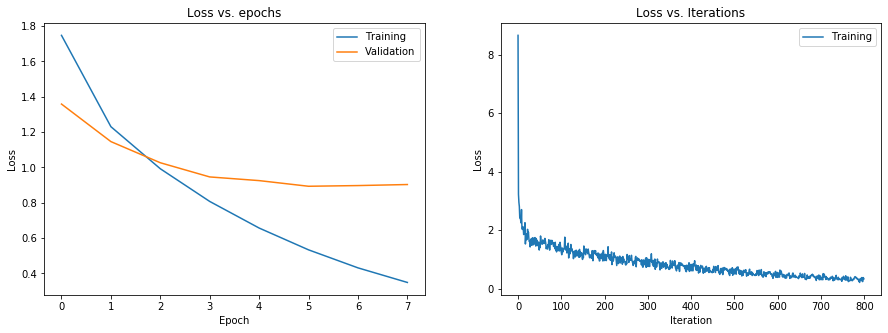

In [48]:
# Plot the learning curves

import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(epoch_history['loss'])
plt.plot(epoch_history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.subplot(122)
plt.plot(batch_history['loss'])
plt.title('Loss vs. Iterations')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(['Training'], loc='upper right')
plt.show() 

## 7. Use the model to translate
Now it's time to put your model into practice! You should run your translation for five randomly sampled English sentences from the dataset. For each sentence, the process is as follows:
* Preprocess and embed the English sentence according to the model requirements.
* Pass the embedded sentence through the encoder to get the encoder hidden and cell states.
* Starting with the special  `"<start>"` token, use this token and the final encoder hidden and cell states to get the one-step prediction from the decoder, as well as the decoder’s updated hidden and cell states.
* Create a loop to get the next step prediction and updated hidden and cell states from the decoder, using the most recent hidden and cell states. Terminate the loop when the `"<end>"` token is emitted, or when the sentence has reached a maximum length.
* Decode the output token sequence into German text and print the English text and the model's German translation.

In [46]:
# Sample a random English sentence to translate

for _ in range(5):
    english_sentence = english[np.random.choice(len(english))]
    print("English input: \t\t", re.sub(r" ([?.!,])", r"\1 ", english_sentence))

    max_translation_length = 10

    german_translation = ["<start>"]
    ger_token = german_tokenizer.texts_to_sequences(german_translation)
    ger_token = np.array(ger_token)

    embedded_sentence = embedding_layer(tf.constant(english_sentence.split(' ')))

    hidden, cell = encoder(embedded_sentence[np.newaxis, ...])

    while True:
        decoder_output, hidden, cell = decoder(ger_token, hidden_state=hidden, cell_state=cell)
        ger_token = np.argmax(np.squeeze(decoder_output))
        if ger_token == 0:
            break
        ger_word = german_tokenizer.index_word[ger_token]  
        ger_token = ger_token[np.newaxis, np.newaxis, ...]
        if ger_word == "<end>":
            break
        german_translation.append(ger_word)
        if len(german_translation) >= max_translation_length:
            break

    sentence = ' '.join(german_translation[1:])
    print("Model translation:\t", re.sub(r" ([?.!,])", r"\1 ", sentence))
    print('') 

English input: 		 do what you want. 
Model translation:	 tu,  was ich willst! 

English input: 		 tom paid me. 
Model translation:	 tom hat mich aufgezogen. 

English input: 		 it's snowing. 
Model translation:	 es ist weihnachten. 

English input: 		 tom is all alone. 
Model translation:	 tom ist ziemlich brav. 

English input: 		 i downloaded it. 
Model translation:	 ich habe es hier gefunden. 

